In [214]:
#imports and defs
import pythia8
from pyjet import cluster, DTYPE_PTEPM
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
plt.style.use("dark_paper")

def prtStable(pid):
    if abs(pid) == 211: return True #pion
    if abs(pid) == 321: return True #K+-
    if abs(pid) == 11: return True #electron
    if abs(pid) == 13: return True #muon?
    if abs(pid) == 2212: return True #proton
    #
    #if abs(pid) == 22: return True #gamma
    #if abs(pid) == 130: return True #K_l
    return False
def heavyFlavor(pid):
    if abs(pid) == 411: return True
    if abs(pid) == 421: return True
    if abs(pid) == 431: return True
    if abs(pid) == 4122: return True
    if abs(pid) == 511: return True
    if abs(pid) == 521: return True
    if abs(pid) == 531: return True
    if abs(pid) == 5122: return True
    return False
def getData(prt):
    data = [prt.index(),prt.name(),prt.id(),prt.status(),prt.mother1(),prt.mother2(),
            prt.daughter1(),prt.daughter2(),prt.e(),prt.px(),prt.py(),prt.pz(),prt.m(),prt.pT(),prt.eta(),prt.phi(),prt.theta()]
    keys = ["N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","pT","eta","phi","theta"]
    return {key:value for key,value in zip(keys,data)}
def getInfo(prt):
    string = "{:^2d} {:^11s} {:^5d} {:^6d} {:<3d} {:>3d}  {:<3d} {:>3d}    ".format(prt.index(),prt.name(),prt.id(),
                                                                       prt.status(),
                                                                       prt.mother1(),prt.mother2(),
                                                                       prt.daughter1(),prt.daughter2())
    string += (5*" {:>8.3f} ").format(prt.e(),prt.px(),prt.py(),prt.pz(),prt.m())
    return string

In [46]:
# Setup Pythia Parameters
# Generator. Shorthand for event.
pythia = pythia8.Pythia()

# Set up incoming beams, for frame with unequal beam energies.
pythia.readString("Beams:frameType = 2")
# BeamA = proton.
pythia.readString("Beams:idA = 2212")
pythia.settings.parm("Beams:eA", 100.)
# BeamB = electron.
pythia.readString("Beams:idB = 11")#11
pythia.settings.parm("Beams:eB", 10.) # used a 100 was good before
# Phase-space cut: minimal Q2 of process.
pythia.settings.parm("PhaseSpace:Q2Min", 10.)
# Set up DIS process within some phase space.
# Neutral current (with gamma/Z interference).
pythia.readString("WeakBosonExchange:ff2ff(t:gmZ) = on")
# Uncomment to allow charged current.
pythia.readString("WeakBosonExchange:ff2ff(t:W) = on")
# Set dipole recoil on. Necessary for DIS + shower.
pythia.readString("SpaceShower:dipoleRecoil = on")
# Allow emissions up to the kinematical limit,
# since rate known to match well to matrix elements everywhere.
pythia.readString("SpaceShower:pTmaxMatch = 2")
# QED radiation off lepton not handled yet by the new procedure.
pythia.readString("PDF:lepton = off")
pythia.readString("TimeShower:QEDshowerByL = off")
# # QCD pp
# pythia.readString("HardQCD:all = on");
# pythia.readString("PhaseSpace:pTHatMin = .2");
# Initialize.
print("Pythia generator initialized successfully: ", pythia.init())

Pythia generator initialized successfully:  True


In [47]:
def selection(prt):
    sel = prt.isFinal() and prt.vProd().pAbs()<1000 #and prtStable(prt.id()) # and prt.isCharged()
    return sel

In [481]:
#%%capture out
nEvents = 10
events = list()
events_breit = list()
boost_vec = list()
scalars = list()
targets = list()

for iEvent in range(1,nEvents+1):
    if not pythia.next(): continue
    event = pythia.event
    
    ki  = event[2].p() #in e
    kf = event[6].p() # out e
    P  = event[1].p() # in p 
    q  = ki - kf
    Q2 = -q.m2Calc() # Q^2
    xB = Q2/(2*(P*q)) #Bjorken X
    y  = P*q/(P*ki)
    s  = (ki+P).mCalc()
    vec = P*xB*2+q
    boost_vec.append([vec.e(),vec.px(),vec.py,vec.pz()])
    scalars.append([Q2,xB,y,s])
    targets.append(P*xB+q)
    mat = RotBstMatrix()
#    mat.bstback(P*xB*2+q)
#     ki.rotbst(mat)
#     mat.rot(0., -ki.phi())
#     mat.rot(-ki.theta(), ki.phi())
#     P.rotbst(mat)
#     q.rotbst(mat)
    mat.toCMframe(q, P*xB*2)
#     mat.toCMframe(ki, kf)
    
    print("=="*20 + f" Event {iEvent:^3d}/{nEvents:^3d} " + "=="*20)
    print(("{:^2s} {:^11s} {:^5s} {:^6s} {:^8s} {:^8s}   " + 5*"{:^10s}").format("N","NAME","ID","STATUS","PARENTS","CHILDREN","E", "px", "py", "pz" , "m"))
    df = pd.DataFrame(columns=["N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","eta","phi","theta"])
    for prt in event:
        print(getInfo(prt))
        if selection(prt) or prt.index()in[1,2,5]:
            df = df.append(getData(prt),ignore_index=True)

    df.name = f"Event{iEvent}"
    #prt = event[5] #get outgoing parton
    #get outgoing parton daughters
#     df.fs_daughters = np.unique([daughterid for daughterid in prt.daughterListRecursive()\
#                     if selection(event[daughterid])])
    events.append(df)
    
    print("=="*24 + "=="*24)
    df = pd.DataFrame(columns=["N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","eta","phi","theta"])
    for prt in event:
        prt.rotbst(mat)
        print(getInfo(prt))
        if selection(prt) or prt.index()in[1,2,5]:
            df = df.append(getData(prt),ignore_index=True)
    df.name = f"Event{iEvent}_breit"
    events_breit.append(df)

======================================== Event  1 /10  ========================================
N     NAME      ID   STATUS PARENTS  CHILDREN       E         px        py        pz        m     
0    system     90    -11   0     0  0     0      110.002    -0.000    -0.000    89.998    63.252 
1      p+      2212   -12   0     0  7     0      100.002    -0.000     0.000    99.997     0.938 
2      e-       11    -12   0     0  4     0       10.000    -0.000    -0.000   -10.000     0.001 
3       u        2    -21   7     7  5     6       15.878    -0.000    -0.000    15.878     0.000 
4      e-       11    -21   2     0  5     6       10.000    -0.000    -0.000   -10.000     0.000 
5       u        2    -23   3     4  8     8       15.776     3.235     0.720    15.420     0.330 
6      e-       11     23   3     4  0     0       10.104    -3.235    -0.720    -9.545     0.001 
7       u        2    -61   1     0  3     3       25.601     1.148     0.208    25.575     0.000 
8       u    

3       u        2    -21   7     7  5     6        1.740    -0.008    -0.016    -1.740     0.000 
4      e-       11    -21   2     0  5     6      303.960   138.334   270.651     1.757     0.000 
5       u        2    -23   3     4  8     8        1.806     0.022     0.044     1.775     0.330 
6      e-       11     23   3     4  0     0      303.942   138.326   270.635    -1.757     0.001 
7       u        2    -61   1     0  3     3        1.746    -0.169    -0.200    -1.726     0.000 
8       u        2    -62   5     5  10   13        1.801    -0.138    -0.139     1.759     0.330 
9     ud_0     2101   -63   1     0  10   13        4.760     0.146     0.155    -4.720     0.579 
10     pi+      211    83   8     9  0     0        1.063    -0.343    -0.212     0.973     0.140 
11    rho0      113   -83   8     9  14   15        0.817     0.298    -0.350    -0.207     0.643 
12   Delta-    1114   -83   8     9  16   17        1.943     0.395     0.546    -1.354     1.219 
13    rho+

46    gamma     22     91   36    0  0     0        0.022     0.016     0.007    -0.014     0.000 
47     pi+      211    91   37    0  0     0        0.321    -0.068     0.008    -0.281     0.140 
48     pi-     -211    91   37    0  0     0        1.893     0.281     0.226    -1.853     0.140 
49    gamma     22     91   38    0  0     0        0.036     0.030    -0.009    -0.019     0.000 
50    gamma     22     91   38    0  0     0        0.167    -0.016    -0.057     0.157     0.000 
51    gamma     22     91   39    0  0     0        0.221    -0.030    -0.206     0.072     0.000 
52    gamma     22     91   39    0  0     0        0.393    -0.050    -0.271     0.280     0.000 
53    gamma     22     91   40    0  0     0        0.425    -0.031    -0.406     0.122     0.000 
54    gamma     22     91   40    0  0     0        0.023     0.007     0.004     0.022     0.000 
55    gamma     22     91   43    0  0     0        0.106    -0.050    -0.026    -0.090     0.000 
56    gamm

6      e-       11    -23   3     4  10   10        9.625    -2.320    -2.750    -8.927     0.001 
7       u        2    -41   15   15  11    3       12.655    -0.000     0.000    12.655     0.000 
8      e-       11    -42   2     0  4     4       10.000    -0.000    -0.000   -10.000     0.000 
9       u        2    -44   5     5  12   13        4.543     1.282     2.986     3.157     0.330 
10     e-       11     44   6     6  0     0        9.625    -2.320    -2.750    -8.927     0.001 
11      g       21    -43   7     0  14   14        8.490     1.038    -0.236     8.423     0.000 
12      u        2    -51   9     0  16   16        3.554     0.309     2.527     2.458     0.330 
13      g       21    -51   9     0  17   17        2.759     1.190     0.410     2.455     0.000 
14      g       21    -52   11   11  18   18        6.719     0.822    -0.187     6.666     0.000 
15      u        2    -61   1     0  7     7       12.052    -0.708     0.312    12.027     0.000 
16      u 

37    gamma     22     91   26    0  0     0        8.724    -0.152     0.013     8.722     0.000 
38    gamma     22     91   26    0  0     0        0.931    -0.043     0.036     0.929     0.000 
0    system     90    -11   0     0  0     0      132.321    15.146     0.459  -115.232    63.252 
1      p+      2212   -12   0     0  7     0      117.059     0.000     0.000  -117.055     0.938 
2      e-       11    -12   0     0  4     0       15.262    15.146     0.459     1.823     0.001 
3       u        2    -21   7     7  5     6        1.836    -0.000    -0.000    -1.836     0.000 
4      e-       11    -21   2     0  5     6       15.263    15.146     0.459     1.823     0.000 
5       u        2    -23   3     4  8     8        1.839     0.003     0.000     1.810     0.330 
6      e-       11     23   3     4  0     0       15.262    15.146     0.459    -1.823     0.001 
7       u        2    -61   1     0  3     3        1.936    -0.223     0.828    -1.736     0.000 
8       u 

22     pi0      111   -91   10    0  28   29        0.922     0.648     0.157     0.621     0.135 
23     pi+      211    91   12    0  0     0        1.178    -0.160    -0.009    -1.158     0.140 
24     pi-     -211    91   12    0  0     0        1.064    -0.479     0.029    -0.939     0.140 
25     pi0      111   -91   12    0  30   31        0.895     0.023    -0.130    -0.875     0.135 
26    gamma     22     91   19    0  0     0        0.061     0.007    -0.051    -0.033     0.000 
27    gamma     22     91   19    0  0     0        0.197    -0.182    -0.073    -0.016     0.000 
28    gamma     22     91   22    0  0     0        0.294     0.191    -0.005     0.224     0.000 
29    gamma     22     91   22    0  0     0        0.627     0.458     0.162     0.397     0.000 
30    gamma     22     91   25    0  0     0        0.806    -0.019    -0.119    -0.797     0.000 
31    gamma     22     91   25    0  0     0        0.089     0.042    -0.012    -0.078     0.000 


In [482]:
vec = P*xB*2+q
show(vec)
vec.rotbst(mat)
show(vec)

3.18e+01 -4.58e+00 -1.86e+00 3.10e+01 
5.05e+00 0.00e+00 0.00e+00 4.44e-15 


In [483]:
vec = q*2
show(vec)
vec.rotbst(mat)
show(vec)

-4.78e-01 -9.16e+00 -3.71e+00 -2.07e+00 
0.00e+00 1.78e-15 -1.78e-15 1.01e+01 


In [526]:
def cond(x):
    y = x.copy()
    y.iloc[:,:2] = 1
    return abs(y)<1e-10
df = events_breit[9][0:]
df.mask(cond,0)

,N,NAME,ID,STATUS,M1,M2,D1,D2,E,px,py,pz,mass,eta,phi,theta,pT
0,1,p+,2212,-12,0,0,7,0,15.775730,0.000000,0.000000,-15.747803,0.938270,-33.224864,-2.896614,3.141593,0.000000
1,2,e-,11,-12,0,0,4,0,124.256745,-115.140868,-46.647173,2.521950,0.000511,0.020299,-2.756671,1.550499,124.231149
2,5,u,2,-23,3,4,8,8,2.546691,-0.021288,-0.008624,2.525115,0.330000,5.393097,-2.756671,0.009096,0.022968
3,6,e-,11,23,3,4,0,0,124.256745,-115.140868,-46.647173,-2.521950,0.000511,-0.020299,-2.756671,1.591094,124.231149
4,14,pi-,-211,84,8,9,0,0,1.537042,-0.022427,-0.364673,-1.486449,0.139570,-2.111175,-1.632219,2.900575,0.365362
5,15,p+,2212,84,8,9,0,0,5.626277,-0.687931,0.272223,-5.497935,0.938270,-2.703345,2.764788,3.007830,0.739834
6,16,pi+,211,91,11,0,0,0,0.646962,0.051065,-0.521453,-0.352929,0.139570,-0.630901,-1.473179,2.163581,0.523947
7,17,pi-,-211,91,11,0,0,0,0.976694,0.427341,-0.151449,-0.853753,0.139570,-1.390085,-0.340589,2.653416,0.453384
8,18,pi+,211,91,13,0,0,0,1.306548,-0.002131,0.318888,-1.259322,0.139570,-2.082273,1.577480,2.893579,0.318895
9,20,pi+,211,91,10,0,0,0,0.793549,0.146893,0.214990,0.736506,0.139570,1.762796,0.971396,0.339821,0.260381


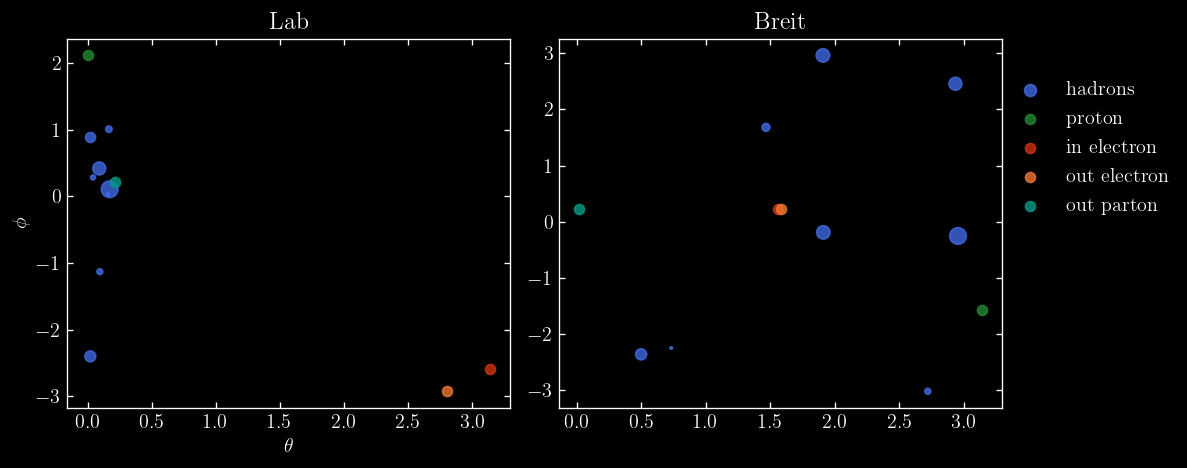

In [527]:
i = 0
for ii in range(1):
    df = events[i]
    df2 = events_breit[i]
    A = 100/df.pT.values[4:].max()
    fig, (ax,ax1) = plt.subplots(1, 2, dpi=120,sharey=False,figsize=(10,4))
    ax.scatter(df.theta[4:], df.phi[4:], s = A*df.pT.values[4:], 
               alpha=.8, label="hadrons")
    ax.scatter(df.theta.values[0], df.phi.values[0],# s = A*df.pT.values[0], 
               alpha=.8, label="proton")
    ax.scatter(df.theta.values[1], df.phi.values[1],# s = A*df.pT.values[1], 
               alpha=.8, label="in electron")
    ax.scatter(df.theta.values[3], df.phi.values[3],# s = A*df.pT.values[3], 
               alpha=.8, label="out electron")
    ax.scatter(df.theta.values[2], df.phi.values[2],# s = A*df.pT.values[2], 
               alpha=.8, label="out parton")
    ax.set_title("Lab")

    A = 100/df2.pT.values[4:].max()
    ax1.scatter(df2.theta[4:], df2.phi[4:], s = A*df2.pT.values[4:], 
                alpha=.8, label="hadrons")
    ax1.scatter(df2.theta.values[0], df2.phi.values[0], #s = A*df2.pT.values[0],
                alpha=.8, label="proton")
    ax1.scatter(df2.theta.values[1], df2.phi.values[1], #s = A*df2.pT.values[1],
                alpha=.8, label="in electron")
    ax1.scatter(df2.theta.values[3], df2.phi.values[3], #s = A*df2.pT.values[3],
                alpha=.8, label="out electron")
    ax1.scatter(df2.theta.values[2], df2.phi.values[2], #s = A*df2.pT.values[2],
                alpha=.8, label="out parton")
    ax1.set_title("Breit")

    plt.legend(loc=(1, .5))
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\phi$")
    fig.tight_layout()
    plt.show()

In [287]:
# test
ki  = event[2].p() #in e
kf = event[6].p() # out e
P   = event[1].p() # in p 
q  = ki - kf
Q2 = -q.m2Calc() # Q^2
xB = Q2/(2*(P*q)) #Bjorken X
y  = P*q/(P*ki)
s  = (ki+P).mCalc()
print(Q2,xB,y,s)
vec = P*xB*2+q
show(vec)
#final quark momentum in Breit Frame

166.06870557537783 0.1750789680124977 0.23713922165669543 63.25181666360273
1.29e+01 1.33e-15 5.33e-15 -7.99e-15 


In [388]:
df2.eta.values[1], df2.phi.values[1]

(0.10753219391220749, 2.065258882620296)

In [135]:
def show(vec):
    string = (4*"{:.2e} ").format(vec.e(),vec.px(),vec.py(),vec.pz())
    print(string)

[2, 4, 24, 3, 5, 2, 34, 12, 24, 3, 9, 3, 3, 3, 5, 23, 17, 3, 4, 3, 28, 5, 5, 4, 2, 3, 4, 3, 2, 2, 39, 5, 2, 10, 2, 2, 3, 28, 2, 3, 21, 2, 4, 4, 2, 2, 2, 3, 3, 2, 4, 9, 3, 29, 19, 3, 4, 4, 3, 20, 4, 6, 38, 4, 2, 38, 4, 31, 23, 18, 16, 24, 4, 2, 3, 2, 3, 29, 22, 21, 4, 21, 3, 2, 25, 4, 20, 3, 26, 36, 3, 27, 21, 20, 3, 49, 5, 13, 43, 3]


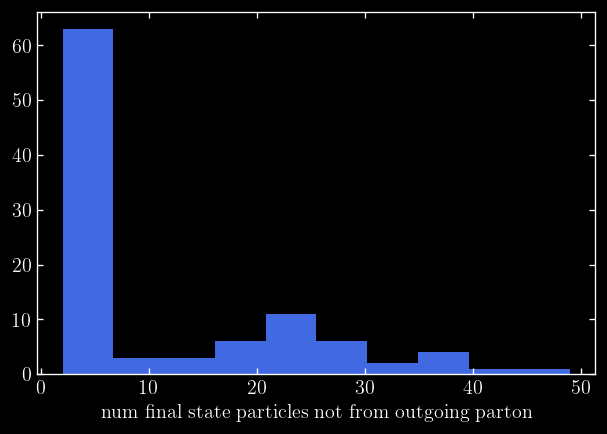

In [7]:
fig, ax = plt.subplots(1, 1, dpi=120)
diff = [len(df)-len(df.fs_daughters) for df in events]
print(diff)
plt.hist(diff)
plt.xlabel("num final state particles not from outgoing parton")
plt.show()

In [37]:
events[i]["N"].isin(events[i].fs_daughters)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
11     True
12     True
13     True
14     True
15    False
16    False
17    False
18    False
19     True
20    False
21    False
22    False
23    False
24    False
25    False
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35    False
36    False
37    False
38    False
39     True
40     True
41    False
42     True
43     True
44     True
45     True
46     True
47     True
48     True
49     True
50     True
51     True
Name: N, dtype: bool

In [34]:
i = 2
print(events[i][1:].px.sum(), events[i][1:].py.sum())
set(events[i].N) - set(events[i].fs_daughters)

-9.43689570931383e-16 -2.7755575615628914e-16


{5,
 21,
 37,
 39,
 40,
 43,
 44,
 46,
 48,
 67,
 68,
 69,
 71,
 75,
 76,
 77,
 78,
 79,
 80,
 96,
 97,
 98,
 99,
 102}

In [35]:
print(events[i].fs_daughters)
events[i]

[ 56  59  60  61  63  66  73  83  87  88  89  90  91  92  93  94 100 101
 103 105 106 107 108 109 110 111 112 113]


,N,NAME,ID,STATUS,M1,M2,D1,D2,E,px,py,pz,mass,eta,phi,theta,pT
0,5,c,4,-23,3,4,9,9,67.890890,2.353594,0.341312,-67.832640,1.500000,-4.044148,0.144013,3.106547,2.378213
1,21,e-,11,44,15,15,0,0,32.182451,-2.353594,-0.341312,-32.094458,0.000511,-3.296851,-2.997579,3.067627,2.378213
2,37,pi+,211,83,35,36,0,0,83.278309,-0.554542,0.126541,83.276250,0.139570,5.679555,2.917244,0.006830,0.568796
3,39,n0,2112,83,35,36,0,0,8.912642,0.353324,0.056407,8.855754,0.939570,3.902407,0.158311,0.040381,0.357799
4,40,nbar0,-2112,83,35,36,0,0,27.426679,-0.420798,0.086574,27.407213,0.939570,4.848888,2.938685,0.015674,0.429612
5,43,pi-,-211,84,35,36,0,0,0.381043,0.180035,-0.092992,-0.290953,0.139570,-1.158652,-0.476776,2.533257,0.202633
6,44,pi+,211,84,35,36,0,0,0.302011,-0.100921,-0.235795,-0.077114,0.139570,-0.296304,-1.975209,1.862857,0.256484
7,46,pi+,211,84,35,36,0,0,0.274680,-0.137192,-0.191053,-0.025424,0.139570,-0.107882,-2.193558,1.678469,0.235208
8,48,pi+,211,84,35,36,0,0,4.887641,-0.270864,-0.157521,-4.875590,0.139570,-3.438896,-2.614849,3.077414,0.313337
9,56,pbar-,-2212,83,50,53,0,0,1.579330,-0.348792,-0.459513,-1.131867,0.938270,-1.426510,-2.220063,2.670227,0.576895


#### Run Selections

In [26]:
from_parton = events[i].loc[events[i].N.isin(events[i].fs_daughters)]
notfrom_parton = events[i].loc[~events[i].N.isin(events[i].fs_daughters)][1:]

In [27]:
print(from_parton[["E","px","py","pz"]].sum(axis=0))

E     950.085952
px      1.203075
py      4.471001
pz    921.590552
dtype: float64


In [28]:
print(events[i].loc[0][["E","px","py","pz"]])

E     14.7263
px    1.08667
py    5.08898
pz   -13.7723
Name: 0, dtype: object


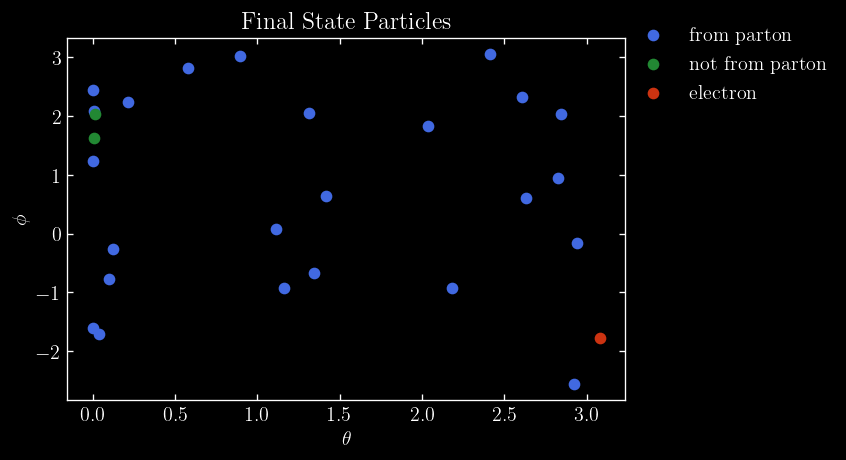

In [41]:
fig, ax = plt.subplots(1, 1, dpi=120)
ax.scatter(from_parton.theta, from_parton.phi, label="from parton")
ax.scatter(notfrom_parton.theta.values[1:], notfrom_parton.phi.values[1:], label="not from parton")
ax.scatter(notfrom_parton.theta.values[0], notfrom_parton.phi.values[0], label="electron")
plt.legend(loc=(1, .8))
plt.title("Final State Particles")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi$")
plt.show()

Text(0, 0.5, '$\\phi$')

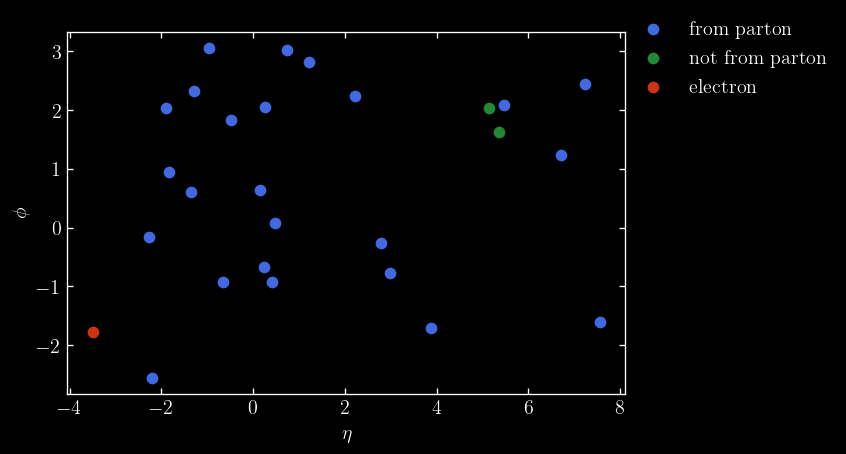

In [42]:
fig, ax = plt.subplots(1, 1, dpi=120)
ax.scatter(from_parton.eta, from_parton.phi, label="from parton")
ax.scatter(notfrom_parton.eta.values[1:], notfrom_parton.phi.values[1:], label="not from parton")
ax.scatter(notfrom_parton.eta.values[0], notfrom_parton.phi.values[0], label="electron")
plt.legend(loc=(1, .8))
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")

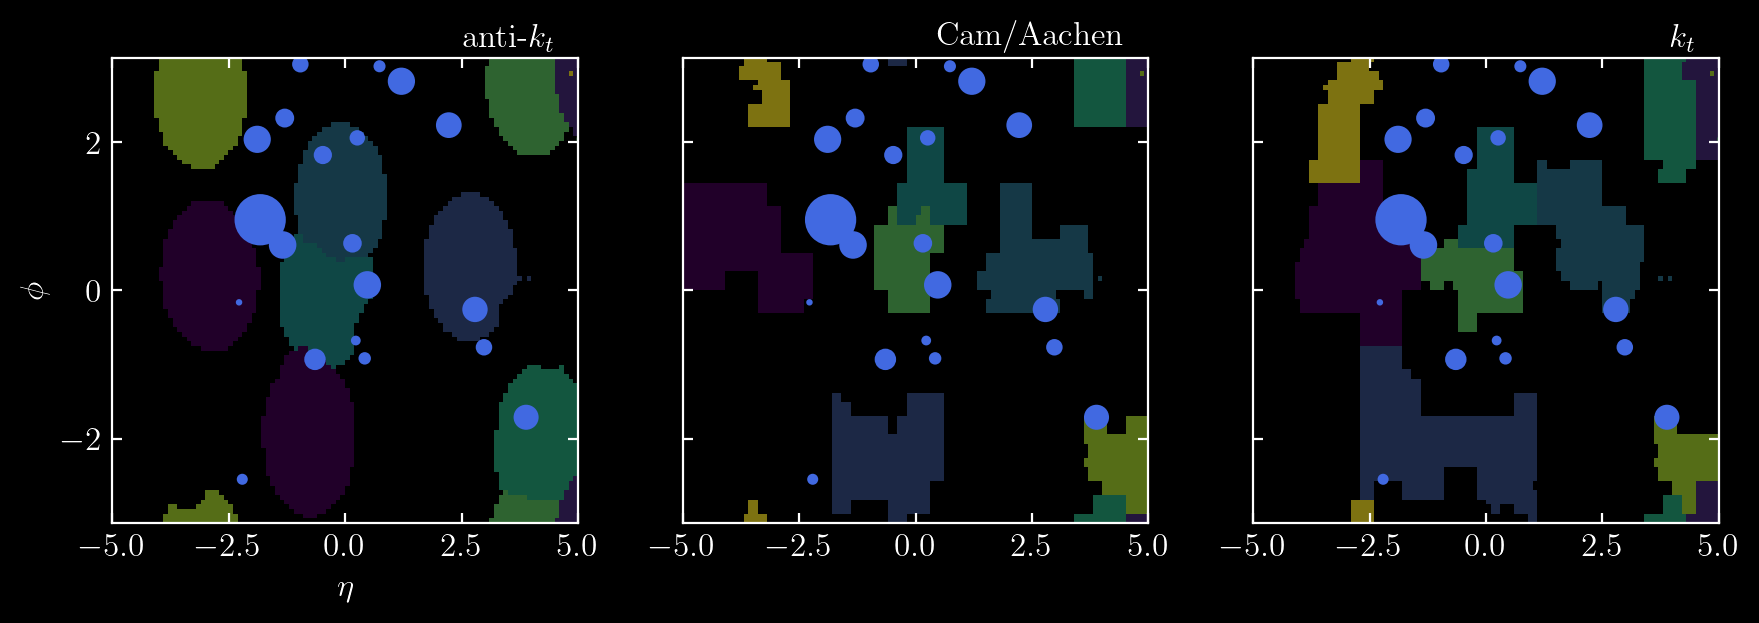

In [43]:
# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -5., 5.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 100

# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins +
                  1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-10
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()
ghosts = ghosts.view(np.recarray)
# add ghosts to the event
eventGen = events[i].to_records()[list(DTYPE_PTEPM.names)][2:]
eventGen1 = from_parton.to_records()[list(DTYPE_PTEPM.names)]
eventGen0 = notfrom_parton.to_records()[list(DTYPE_PTEPM.names)][1:]
event = np.concatenate([eventGen, ghosts], axis=0)

#     fig, axes = plt.subplots(2,2,dpi=120)
#     for ax,name in zip(axes.flatten(),event.dtype.names):
#         data = eventGen[name]
#         bins = np.linspace(data.min(0),data.max(0),30)
#     #     if name == "pT":
#     #         ax.set_xscale("log")
#     #         bins = np.logspace(np.log10(data.min()),np.log10(data.max()),30)
#         ax.hist(data,bins=bins)
#         ax.set_title(name)
#     fig.tight_layout()

# Plot
fig = plt.figure(figsize=(9, 3), dpi=200)

ax = None
for p, label in zip((-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')):
    # cluster
    sequence = cluster(event, algo="genkt", R=1.0, p=p)
    jets = sequence.inclusive_jets(ptmin=7e-1)
#     jets = sequence.inclusive_jets(ptmin=5e-1)
    #jets = sequence.exclusive_jets(6)

    # pick a different color for each jet
    colors = cm.viridis(np.linspace(0, 1, len(jets)), alpha=0.5)
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = fig.add_subplot(1, 3, p + 2, sharey=ax)
    area = np.zeros((eta_edges.shape[0] - 1, phi_edges.shape[0] - 1),
                    dtype=np.float64)
    for ijet, jet in enumerate(jets):
        constit = jet.constituents_array()
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       bins=(eta_edges, phi_edges))
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    ax.scatter(eventGen0['eta'], eventGen0['phi'],
               s=200 * eventGen0['pT'] / eventGen['pT'].max(),
               c="C1")
    ax.scatter(eventGen1['eta'], eventGen1['phi'],
               s=200 * eventGen1['pT'] / eventGen['pT'].max(),
               c="C0")
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    if p == -1:
        ax.set_ylabel(r'$\phi$')
        ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 1.01, label,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            fontsize=12)

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
fig.tight_layout()

In [16]:
sequence = cluster(event, algo="genkt", R=1.0, p=-1.0)
jets = sequence.inclusive_jets(ptmin=.01)

In [17]:
jets

[PseudoJet(pt=4.092, eta=-3.149, phi=0.220, mass=2.813),
 PseudoJet(pt=1.568, eta=-1.110, phi=-1.910, mass=1.912),
 PseudoJet(pt=1.515, eta=5.603, phi=2.923, mass=0.693),
 PseudoJet(pt=1.184, eta=3.467, phi=0.310, mass=2.315),
 PseudoJet(pt=0.980, eta=-0.096, phi=1.258, mass=0.354),
 PseudoJet(pt=0.932, eta=-0.521, phi=-0.060, mass=0.593),
 PseudoJet(pt=0.921, eta=4.344, phi=-1.982, mass=0.434),
 PseudoJet(pt=0.801, eta=4.967, phi=2.799, mass=1.886),
 PseudoJet(pt=0.703, eta=-3.373, phi=2.633, mass=0.605),
 PseudoJet(pt=0.636, eta=4.039, phi=-0.526, mass=0.304),
 PseudoJet(pt=0.542, eta=7.709, phi=-2.821, mass=0.940),
 PseudoJet(pt=0.485, eta=0.767, phi=-0.421, mass=0.240),
 PseudoJet(pt=0.337, eta=-1.111, phi=1.675, mass=0.030),
 PseudoJet(pt=0.328, eta=2.846, phi=-2.864, mass=0.000),
 PseudoJet(pt=0.313, eta=-3.439, phi=-2.615, mass=0.140),
 PseudoJet(pt=0.255, eta=0.955, phi=2.989, mass=0.140),
 PseudoJet(pt=0.180, eta=6.252, phi=0.202, mass=0.140),
 PseudoJet(pt=0.084, eta=5.201, p